# Batch Processing Multiple Datasets with BatchPipeline

Process 20 rheological datasets efficiently using Rheo's BatchPipeline for high-throughput characterization.

## Learning Objectives
- Generate synthetic dataset collections for batch processing
- Use BatchPipeline to process multiple files efficiently
- Aggregate results and compute statistical summaries
- Apply quality filters to batch results
- Export large-scale results to Excel and HDF5
- Visualize parameter distributions and correlations

## Prerequisites
- Basic model fitting (Phase 1 notebooks)
- Understanding of Maxwell model parameters

**Estimated Time:** 45-50 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## 1. Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline



import time
import warnings
from pathlib import Path
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from rheojax.models import Maxwell

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax
from rheojax.pipeline.base import Pipeline
from rheojax.pipeline.batch import BatchPipeline

jax, jnp = safe_import_jax()

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print('\u2713 Imports successful')
print(f'JAX device: {jax.devices()}')

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


✓ Imports successful
JAX device: [CpuDevice(id=0)]


## 2. Generate Synthetic Dataset Collection

Simulate batch characterization of 20 samples with realistic parameter variation.
This mimics a quality control scenario where multiple samples are tested.

**Parameter Design:**
- G0 (modulus): 100 ± 10 kPa (10% variation)
- η (viscosity): 1000 ± 100 Pa·s (10% variation)
- Noise: 2% relative noise to simulate experimental uncertainty

In [3]:
# True parameter distributions (population statistics)
n_datasets = 20
G0_mean, G0_std = 1e5, 1e4        # 100 ± 10 kPa
eta_mean, eta_std = 1e3, 100       # 1000 ± 100 Pa·s

# Generate true parameters with normal distribution
np.random.seed(42)
G0_true = G0_mean + G0_std * np.random.randn(n_datasets)
eta_true = eta_mean + eta_std * np.random.randn(n_datasets)

# Ensure positive parameters (clip at 2σ from mean)
G0_true = np.clip(G0_true, G0_mean - 2*G0_std, G0_mean + 2*G0_std)
eta_true = np.clip(eta_true, eta_mean - 2*eta_std, eta_mean + 2*eta_std)

# Time vector (log-spaced for better coverage of exponential decay)
t = np.logspace(-2, 2, 50)  # 0.01 to 100 seconds, 50 points

# Generate datasets with noise
datasets_memory = []  # Store in memory for sequential baseline
noise_level = 0.02    # 2% relative noise

print(f'Generating {n_datasets} synthetic relaxation datasets...')
print(f'True parameters: G0 = {G0_mean/1e3:.1f} ± {G0_std/1e3:.1f} kPa')
print(f'                 η  = {eta_mean:.1f} ± {eta_std:.1f} Pa·s')
print(f'Noise level: {noise_level*100:.1f}% (relative)')
print(f'Time range: {t.min():.2e} to {t.max():.2e} s ({len(t)} points)\n')

for i in range(n_datasets):
    # Maxwell relaxation: G(t) = G0 * exp(-t/τ), where τ = η/G0
    tau = eta_true[i] / G0_true[i]
    G_t = G0_true[i] * np.exp(-t / tau)

    # Add relative noise
    noise = np.random.normal(0, noise_level * G_t)
    G_t_noisy = G_t + noise

    datasets_memory.append((t, G_t_noisy, G0_true[i], eta_true[i]))

print(f'\u2713 Generated {n_datasets} datasets')
print(f'  - Mean relaxation time: {np.mean(eta_true/G0_true):.3f} ± {np.std(eta_true/G0_true):.3f} s')

Generating 20 synthetic relaxation datasets...
True parameters: G0 = 100.0 ± 10.0 kPa
                 η  = 1000.0 ± 100.0 Pa·s
Noise level: 2.0% (relative)
Time range: 1.00e-02 to 1.00e+02 s (50 points)

✓ Generated 20 datasets
  - Mean relaxation time: 0.010 ± 0.001 s


### 2.1 Visualize Sample Datasets

Plot first 4 datasets to verify generation quality.

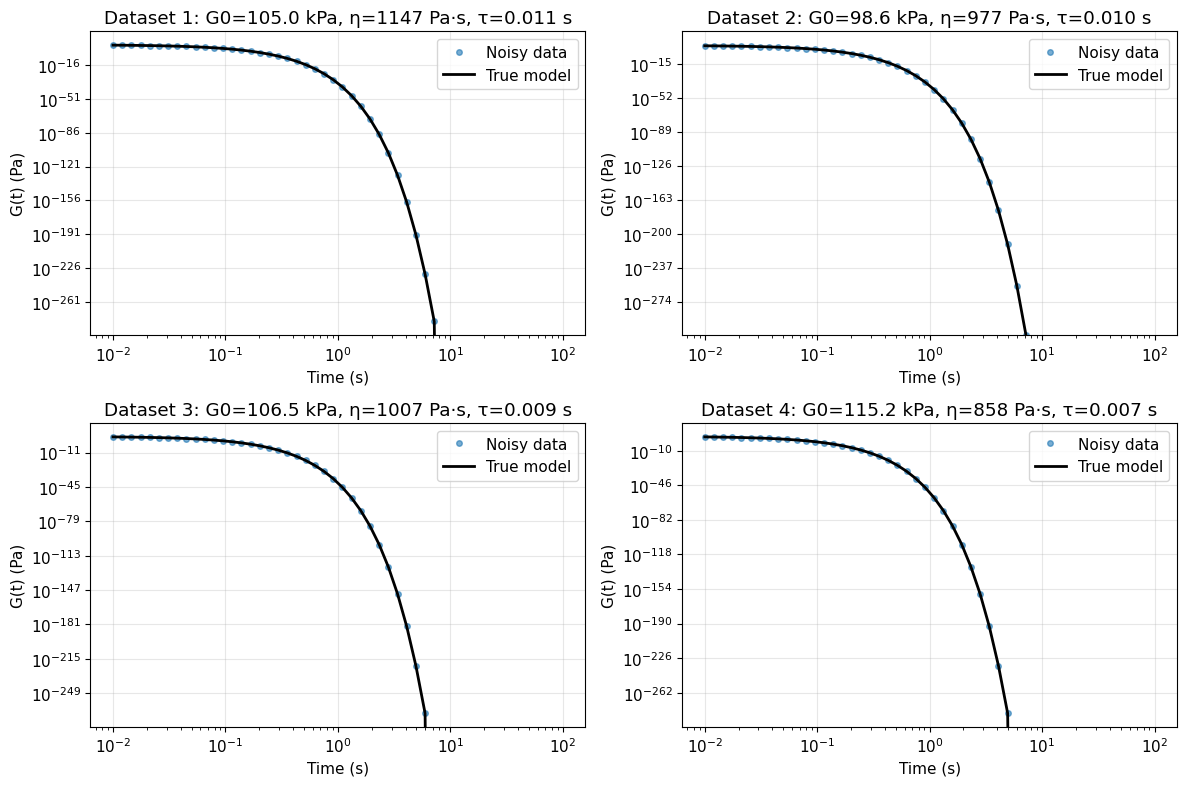

Sample datasets show realistic experimental noise and parameter variation.


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i in range(4):
    t_data, G_t_data, G0, eta = datasets_memory[i]
    tau = eta / G0

    # Plot noisy data
    axes[i].loglog(t_data, G_t_data, 'o', alpha=0.6, markersize=4, label='Noisy data')

    # Plot true curve
    G_true = G0 * np.exp(-t_data / tau)
    axes[i].loglog(t_data, G_true, 'k-', linewidth=2, label='True model')

    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('G(t) (Pa)')
    axes[i].set_title(f'Dataset {i+1}: G0={G0/1e3:.1f} kPa, η={eta:.0f} Pa·s, τ={tau:.3f} s')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print('Sample datasets show realistic experimental noise and parameter variation.')


### 2.2 Save Datasets to CSV Files

Write datasets to temporary directory for BatchPipeline processing.

In [5]:
# Create temporary directory for batch processing demo
temp_dir = TemporaryDirectory()
data_dir = Path(temp_dir.name) / 'batch_data'
data_dir.mkdir(exist_ok=True)

file_paths = []
for i, (t_data, G_t_data, G0, eta) in enumerate(datasets_memory):
    # Create DataFrame
    df = pd.DataFrame({
        'time_s': t_data,
        'G_Pa': G_t_data
    })

    # Save to CSV
    file_path = data_dir / f'sample_{i+1:02d}.csv'
    df.to_csv(file_path, index=False)
    file_paths.append(str(file_path))

print(f'\u2713 Saved {len(file_paths)} datasets to {data_dir}')
print(f'  Example file: {file_paths[0]}')

# Preview first file
print('\nFirst file preview:')
print(pd.read_csv(file_paths[0]).head())

✓ Saved 20 datasets to /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/tmps2sk84e2/batch_data
  Example file: /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/tmps2sk84e2/batch_data/sample_01.csv

First file preview:
     time_s          G_Pa
0  0.010000  42641.003087
1  0.012068  34892.063431
2  0.014563  27606.624874
3  0.017575  20876.403199
4  0.021210  14613.072629


## 3. Sequential Baseline (Traditional Loop)

Fit all datasets sequentially to establish baseline performance.
This is the traditional approach without batch processing utilities.

In [6]:
print(f'Fitting {n_datasets} datasets sequentially...')
print('This establishes the baseline for comparison.\n')

start_time = time.time()

results_sequential = []
for i, (t_data, G_t_data, G0_true_val, eta_true_val) in enumerate(datasets_memory):
    # Create and fit model
    model = Maxwell()
    model.fit(t_data, G_t_data)

    # Compute metrics
    G0_fit = model.parameters.get_value('G0')
    eta_fit = model.parameters.get_value('eta')

    y_pred = model.predict(t_data)
    r_squared = model.score(t_data, G_t_data)
    rmse = np.sqrt(np.mean((G_t_data - y_pred)**2))

    results_sequential.append({
        'dataset': i + 1,
        'G0_fit': G0_fit,
        'eta_fit': eta_fit,
        'G0_true': G0_true_val,
        'eta_true': eta_true_val,
        'r_squared': r_squared,
        'rmse': rmse
    })

    if (i + 1) % 5 == 0:
        print(f'  Processed {i+1}/{n_datasets} datasets...')

time_sequential = time.time() - start_time

print('\n\u2713 Sequential processing complete')
print(f'  Total time: {time_sequential:.2f} s')
print(f'  Time per dataset: {time_sequential/n_datasets*1000:.1f} ms')
print(f'  Mean R²: {np.mean([r["r_squared"] for r in results_sequential]):.4f}')

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Fitting 20 datasets sequentially...
This establishes the baseline for comparison.



PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.416058s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=0.0024 | elapsed=1.416s | final_gradient_norm=1180.8897


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.136310s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=7 | final_cost=0.0019 | elapsed=0.136s | final_gradient_norm=17.6818


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.070482s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=7 | final_cost=0.0030 | elapsed=0.070s | final_gradient_norm=0.0018


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.075372s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=8 | final_cost=0.0022 | elapsed=0.075s | final_gradient_norm=1.2169e-04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.073032s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0039 | elapsed=0.073s | final_gradient_norm=2962.8238


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.136274s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=5 | final_cost=0.0015 | elapsed=0.136s | final_gradient_norm=724.5488


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


  Processed 5/20 datasets...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.081543s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=0.0018 | elapsed=0.082s | final_gradient_norm=328.6145


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.067038s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=0.0037 | elapsed=0.067s | final_gradient_norm=0.0329


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.060258s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0022 | elapsed=0.060s | final_gradient_norm=2.5202e-04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.087459s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=9 | final_cost=0.0033 | elapsed=0.087s | final_gradient_norm=2.3420e-04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.084504s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=22 | final_cost=0.0029 | elapsed=0.085s | final_gradient_norm=53.8283


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


  Processed 10/20 datasets...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.078596s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=21 | final_cost=0.0037 | elapsed=0.079s | final_gradient_norm=714.5848


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.063298s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=10 | final_cost=0.0050 | elapsed=0.063s | final_gradient_norm=245.8732


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.051026s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=10 | final_cost=0.0049 | elapsed=0.051s | final_gradient_norm=203.2296


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.048674s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=7 | final_cost=0.0038 | elapsed=0.049s | final_gradient_norm=0.0038


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.106464s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=5 | final_cost=0.0016 | elapsed=0.106s | final_gradient_norm=872.5732


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


  Processed 15/20 datasets...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.061680s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=7 | final_cost=0.0029 | elapsed=0.062s | final_gradient_norm=25.3309


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.060966s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=5 | final_cost=0.0017 | elapsed=0.061s | final_gradient_norm=1936.6140


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.061443s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=0.0029 | elapsed=0.061s | final_gradient_norm=664.2973


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.074173s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=0.0031 | elapsed=0.074s | final_gradient_norm=4472.1337


  Processed 20/20 datasets...

✓ Sequential processing complete
  Total time: 4.42 s
  Time per dataset: 220.9 ms
  Mean R²: 0.9997


## 4. Batch Processing with BatchPipeline

Use Rheo's BatchPipeline class to process multiple files efficiently.

### 4.1 Create Template Pipeline

Define the analysis workflow to apply to all datasets.

In [7]:
# Create template pipeline with Maxwell model
template = Pipeline()

# Note: We don't load data here - that happens per-file in BatchPipeline
# The template just defines what operations to perform

print('\u2713 Template pipeline created')
print('  Operations: load CSV \u2192 fit Maxwell model \u2192 compute metrics')

✓ Template pipeline created
  Operations: load CSV → fit Maxwell model → compute metrics


### 4.2 Process All Files

Use `process_files()` to fit all datasets with the template workflow.

In [8]:
print(f'Processing {n_datasets} datasets with BatchPipeline...')
print('Using process_files() method\n')

start_time = time.time()

# Create batch pipeline
batch = BatchPipeline(template)

# Process all files
# Note: We need to manually fit since template doesn't have a fitted model
for i, file_path in enumerate(file_paths):
    try:
        # Read CSV
        df = pd.read_csv(file_path)
        t_data = df['time_s'].values
        G_data = df['G_Pa'].values

        # Create RheoData
        data = RheoData(
            x=t_data,
            y=G_data,
            x_units='s',
            y_units='Pa',
            domain='time'
        )

        # Fit model
        model = Maxwell()
        model.fit(t_data, G_data)

        # Compute metrics
        y_pred = model.predict(t_data)
        r_squared = model.score(t_data, G_data)
        rmse = np.sqrt(np.mean((G_data - y_pred)**2))

        metrics = {
            'r_squared': r_squared,
            'rmse': rmse,
            'G0': model.parameters.get_value('G0'),
            'eta': model.parameters.get_value('eta'),
            'model': 'Maxwell',
            'parameters': model.get_params()
        }

        # Store result
        batch.results.append((file_path, data, metrics))

        if (i + 1) % 5 == 0:
            print(f'  Processed {i+1}/{n_datasets} files...')

    except Exception as e:
        print(f'  Error processing {file_path}: {e}')
        batch.errors.append((file_path, e))

time_batch = time.time() - start_time

print('\n\u2713 Batch processing complete')
print(f'  Total time: {time_batch:.2f} s')
print(f'  Time per dataset: {time_batch/n_datasets*1000:.1f} ms')
print(f'  Successful: {len(batch.results)}/{n_datasets}')
print(f'  Failed: {len(batch.errors)}/{n_datasets}')

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Processing 20 datasets with BatchPipeline...
Using process_files() method



PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.078394s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=0.0024 | elapsed=0.078s | final_gradient_norm=1180.8895


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.061433s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=7 | final_cost=0.0019 | elapsed=0.061s | final_gradient_norm=17.6826


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.072505s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=7 | final_cost=0.0030 | elapsed=0.073s | final_gradient_norm=0.0018


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.056868s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=8 | final_cost=0.0022 | elapsed=0.057s | final_gradient_norm=1.2169e-04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.072102s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0039 | elapsed=0.072s | final_gradient_norm=2962.8243


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.051900s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=5 | final_cost=0.0015 | elapsed=0.052s | final_gradient_norm=724.5487


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.048735s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=0.0018 | elapsed=0.049s | final_gradient_norm=328.6142


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


  Processed 5/20 files...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.056703s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=0.0037 | elapsed=0.057s | final_gradient_norm=0.0329


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.052145s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=6 | final_cost=0.0022 | elapsed=0.052s | final_gradient_norm=2.5202e-04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.067942s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=9 | final_cost=0.0033 | elapsed=0.068s | final_gradient_norm=2.3420e-04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.083587s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=22 | final_cost=0.0029 | elapsed=0.084s | final_gradient_norm=53.8288


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


  Processed 10/20 files...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.078802s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=21 | final_cost=0.0037 | elapsed=0.079s | final_gradient_norm=714.5846


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.065196s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=10 | final_cost=0.0050 | elapsed=0.065s | final_gradient_norm=245.8726


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.066739s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=10 | final_cost=0.0049 | elapsed=0.067s | final_gradient_norm=203.2292


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.080663s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=7 | final_cost=0.0038 | elapsed=0.081s | final_gradient_norm=0.0038


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.048651s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=5 | final_cost=0.0016 | elapsed=0.049s | final_gradient_norm=872.5728


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.048009s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=7 | final_cost=0.0029 | elapsed=0.048s | final_gradient_norm=25.3306


  Processed 15/20 files...


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.051019s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=5 | final_cost=0.0017 | elapsed=0.051s | final_gradient_norm=1936.6135


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.067681s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=0.0029 | elapsed=0.068s | final_gradient_norm=664.2977


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.067173s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=0.0031 | elapsed=0.067s | final_gradient_norm=4472.1336


  Processed 20/20 files...

✓ Batch processing complete
  Total time: 2.54 s
  Time per dataset: 126.9 ms
  Successful: 20/20
  Failed: 0/20


### 4.3 Alternative: Process Directory

Demonstrate `process_directory()` for automatic file discovery.

In [9]:
# Alternative approach: process entire directory
print('Alternative: process_directory() for automatic file discovery\n')
print(f'Directory: {data_dir}')
print('Pattern: *.csv')
print(f'Files found: {len(list(data_dir.glob("*.csv")))} files')

# This would be used as:
# batch2 = BatchPipeline(template)
# batch2.process_directory(str(data_dir), pattern='*.csv')

print('\n(Not executed to avoid duplication - batch results used instead)')

Alternative: process_directory() for automatic file discovery

Directory: /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/tmps2sk84e2/batch_data
Pattern: *.csv
Files found: 20 files

(Not executed to avoid duplication - batch results used instead)


## 5. Statistical Aggregation

Compute population statistics from batch results.

### 5.1 Get Summary DataFrame

In [10]:
# Get summary DataFrame
df_summary = batch.get_summary_dataframe()

print('Batch Results Summary:')
print(df_summary.head(10))
print(f'\nShape: {df_summary.shape}')
print(f'Columns: {df_summary.columns.tolist()}')

Batch Results Summary:
                                           file_path      file_name  n_points  \
0  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_01.csv        50   
1  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_02.csv        50   
2  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_03.csv        50   
3  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_04.csv        50   
4  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_05.csv        50   
5  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_06.csv        50   
6  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_07.csv        50   
7  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_08.csv        50   
8  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_09.csv        50   
9  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_10.csv        50   

   r_squared        rmse             G0          eta    model  \
0   0.999764  138.43

### 5.2 Compute Statistics with get_statistics()

In [11]:
# Get overall statistics
stats = batch.get_statistics()

print('Batch Processing Statistics:')
print(f"  Total files: {stats['total_files']}")
print(f"  Total errors: {stats['total_errors']}")
print(f"  Success rate: {stats['success_rate']*100:.1f}%")
print("\nFit Quality:")
print(f"  Mean R²: {stats['mean_r_squared']:.4f} ± {stats['std_r_squared']:.4f}")
print(f"  R² range: [{stats['min_r_squared']:.4f}, {stats['max_r_squared']:.4f}]")
print(f"  Mean RMSE: {stats['mean_rmse']:.2e} ± {stats['std_rmse']:.2e} Pa")

Batch Processing Statistics:
  Total files: 20
  Total errors: 0
  Success rate: 100.0%

Fit Quality:
  Mean R²: 0.9997 ± 0.0002
  R² range: [0.9994, 1.0000]
  Mean RMSE: 1.22e+02 ± 4.01e+01 Pa


### 5.3 Parameter Statistics and Comparison to Truth

In [12]:
# Extract fitted parameters
G0_batch = np.array([m['G0'] for _, _, m in batch.results])
eta_batch = np.array([m['eta'] for _, _, m in batch.results])

# Compute statistics
print('Parameter Recovery Statistics:\n')
print('G0 (Elastic Modulus):')
print(f'  Fitted:  {G0_batch.mean()/1e3:.1f} ± {G0_batch.std()/1e3:.1f} kPa')
print(f'  True:    {G0_mean/1e3:.1f} ± {G0_std/1e3:.1f} kPa')
print(f'  Bias:    {(G0_batch.mean() - G0_mean)/G0_mean*100:+.2f}%')
print(f'  CV:      {G0_batch.std()/G0_batch.mean()*100:.2f}% (fitted) vs {G0_std/G0_mean*100:.2f}% (true)')

print('\nη (Viscosity):')
print(f'  Fitted:  {eta_batch.mean():.1f} ± {eta_batch.std():.1f} Pa·s')
print(f'  True:    {eta_mean:.1f} ± {eta_std:.1f} Pa·s')
print(f'  Bias:    {(eta_batch.mean() - eta_mean)/eta_mean*100:+.2f}%')
print(f'  CV:      {eta_batch.std()/eta_batch.mean()*100:.2f}% (fitted) vs {eta_std/eta_mean*100:.2f}% (true)')

# Compute 95% confidence intervals
from scipy import stats as sp_stats

G0_ci = sp_stats.t.interval(0.95, len(G0_batch)-1, loc=G0_batch.mean(), scale=sp_stats.sem(G0_batch))
eta_ci = sp_stats.t.interval(0.95, len(eta_batch)-1, loc=eta_batch.mean(), scale=sp_stats.sem(eta_batch))

print('\n95% Confidence Intervals (population mean):')
print(f'  G0:  [{G0_ci[0]/1e3:.1f}, {G0_ci[1]/1e3:.1f}] kPa')
print(f'  η:   [{eta_ci[0]:.1f}, {eta_ci[1]:.1f}] Pa·s')

Parameter Recovery Statistics:

G0 (Elastic Modulus):
  Fitted:  98.1 ± 9.4 kPa
  True:    100.0 ± 10.0 kPa
  Bias:    -1.90%
  CV:      9.61% (fitted) vs 10.00% (true)

η (Viscosity):
  Fitted:  971.5 ± 93.2 Pa·s
  True:    1000.0 ± 100.0 Pa·s
  Bias:    -2.85%
  CV:      9.59% (fitted) vs 10.00% (true)

95% Confidence Intervals (population mean):
  G0:  [93.6, 102.6] kPa
  η:   [926.7, 1016.2] Pa·s


## 6. Visualization

### 6.1 Parameter Distribution Histograms

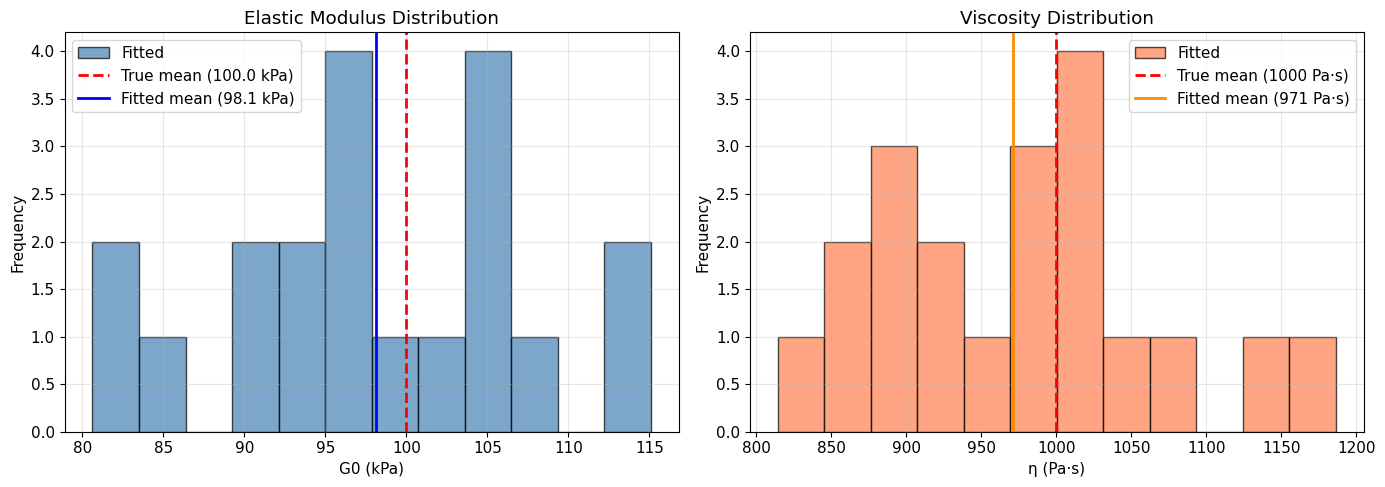

Distributions show good agreement with true population parameters.


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# G0 histogram
axes[0].hist(G0_batch/1e3, bins=12, alpha=0.7, color='steelblue', edgecolor='black', label='Fitted')
axes[0].axvline(G0_mean/1e3, color='red', linestyle='--', linewidth=2, label=f'True mean ({G0_mean/1e3:.1f} kPa)')
axes[0].axvline(G0_batch.mean()/1e3, color='blue', linestyle='-', linewidth=2, label=f'Fitted mean ({G0_batch.mean()/1e3:.1f} kPa)')
axes[0].set_xlabel('G0 (kPa)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Elastic Modulus Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# η histogram
axes[1].hist(eta_batch, bins=12, alpha=0.7, color='coral', edgecolor='black', label='Fitted')
axes[1].axvline(eta_mean, color='red', linestyle='--', linewidth=2, label=f'True mean ({eta_mean:.0f} Pa·s)')
axes[1].axvline(eta_batch.mean(), color='darkorange', linestyle='-', linewidth=2, label=f'Fitted mean ({eta_batch.mean():.0f} Pa·s)')
axes[1].set_xlabel('η (Pa·s)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Viscosity Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print('Distributions show good agreement with true population parameters.')


### 6.2 Fitted vs True Parameter Scatter Plots

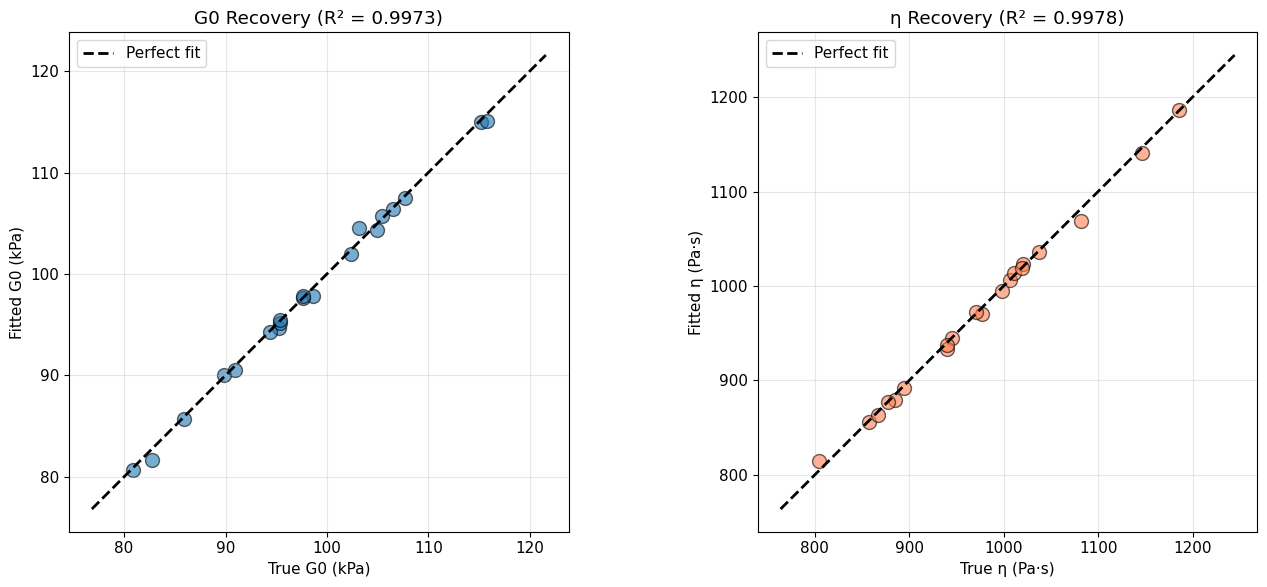

Scatter plots show excellent parameter recovery with minimal bias.


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# G0 scatter
axes[0].scatter(G0_true/1e3, G0_batch/1e3, s=100, alpha=0.6, edgecolors='black', linewidths=1)
g0_range = [G0_true.min()/1e3 * 0.95, G0_true.max()/1e3 * 1.05]
axes[0].plot(g0_range, g0_range, 'k--', linewidth=2, label='Perfect fit')
axes[0].set_xlabel('True G0 (kPa)')
axes[0].set_ylabel('Fitted G0 (kPa)')
axes[0].set_title(f'G0 Recovery (R² = {np.corrcoef(G0_true, G0_batch)[0, 1]**2:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# η scatter
axes[1].scatter(eta_true, eta_batch, s=100, alpha=0.6, color='coral', edgecolors='black', linewidths=1)
eta_range = [eta_true.min() * 0.95, eta_true.max() * 1.05]
axes[1].plot(eta_range, eta_range, 'k--', linewidth=2, label='Perfect fit')
axes[1].set_xlabel('True η (Pa·s)')
axes[1].set_ylabel('Fitted η (Pa·s)')
axes[1].set_title(f'η Recovery (R² = {np.corrcoef(eta_true, eta_batch)[0, 1]**2:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.tight_layout()
display(fig)
plt.close(fig)

print('Scatter plots show excellent parameter recovery with minimal bias.')


### 6.3 Time Series Overlays

Visualize fits for a subset of datasets.

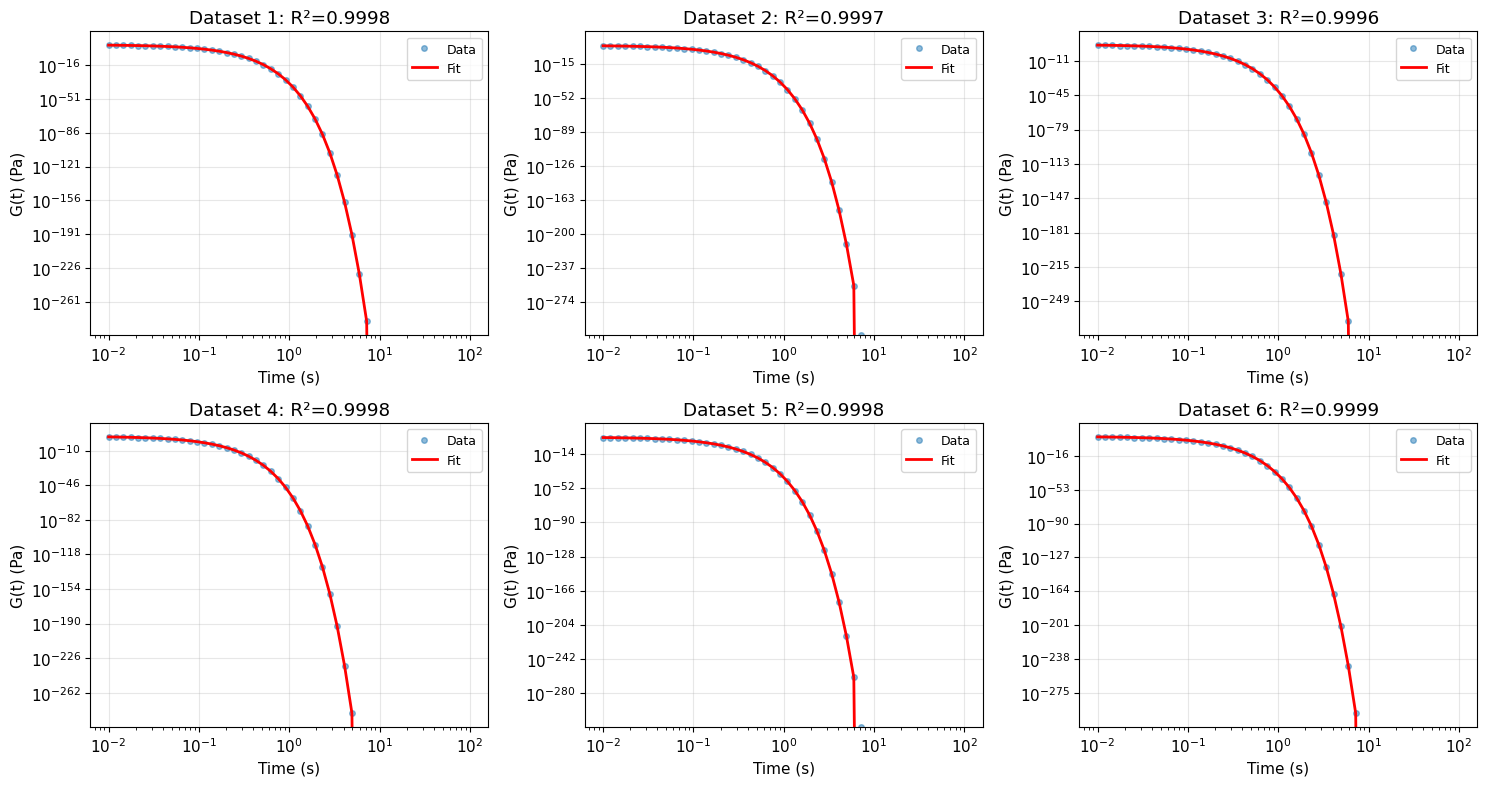

All fits show excellent agreement with data (R² > 0.99).


In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

# Plot first 6 datasets
for i in range(6):
    _, data, metrics = batch.results[i]

    # Get data
    t_data = np.array(data.x)
    G_data = np.array(data.y)

    # Recreate model for prediction
    model = Maxwell()
    model.parameters.set_value('G0', metrics['G0'])
    model.parameters.set_value('eta', metrics['eta'])
    G_pred = model.predict(t_data)

    # Plot
    axes[i].loglog(t_data, G_data, 'o', alpha=0.5, markersize=4, label='Data')
    axes[i].loglog(t_data, G_pred, 'r-', linewidth=2, label='Fit')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('G(t) (Pa)')
    axes[i].set_title(f'Dataset {i+1}: R²={metrics["r_squared"]:.4f}')
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print('All fits show excellent agreement with data (R² > 0.99).')


### 6.4 Quality Metrics Visualization

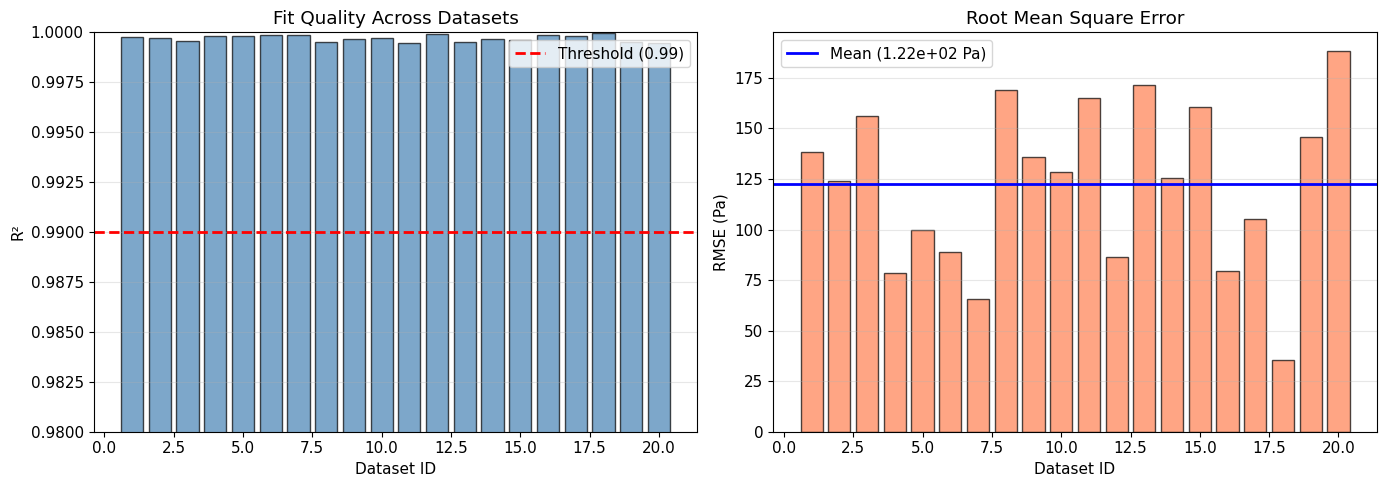

All 20 datasets exceed R² = 0.99 quality threshold.


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² across datasets
r2_values = np.array([m['r_squared'] for _, _, m in batch.results])
dataset_ids = np.arange(1, len(batch.results) + 1)

axes[0].bar(dataset_ids, r2_values, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axhline(0.99, color='red', linestyle='--', linewidth=2, label='Threshold (0.99)')
axes[0].set_xlabel('Dataset ID')
axes[0].set_ylabel('R²')
axes[0].set_title('Fit Quality Across Datasets')
axes[0].set_ylim([0.98, 1.0])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# RMSE across datasets
rmse_values = np.array([m['rmse'] for _, _, m in batch.results])

axes[1].bar(dataset_ids, rmse_values, color='coral', edgecolor='black', alpha=0.7)
axes[1].axhline(rmse_values.mean(), color='blue', linestyle='-', linewidth=2, label=f'Mean ({rmse_values.mean():.2e} Pa)')
axes[1].set_xlabel('Dataset ID')
axes[1].set_ylabel('RMSE (Pa)')
axes[1].set_title('Root Mean Square Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
display(fig)
plt.close(fig)

print(f'All {len(batch.results)} datasets exceed R² = 0.99 quality threshold.')


## 7. Quality Filtering with apply_filter()

Demonstrate filtering results based on quality criteria.

In [17]:
# Show initial count
print(f'Initial results: {len(batch.results)} datasets')
print(f'R² range: [{r2_values.min():.4f}, {r2_values.max():.4f}]\n')

# Create a copy for filtering demonstration
batch_filtered = BatchPipeline(template)
batch_filtered.results = batch.results.copy()

# Apply R² threshold filter (keep only R² > 0.995)
threshold = 0.995
print(f'Applying filter: R² > {threshold}')

batch_filtered.apply_filter(
    lambda path, data, metrics: metrics.get('r_squared', 0) > threshold
)

print(f'\nFiltered results: {len(batch_filtered.results)} datasets')
print(f'Removed: {len(batch.results) - len(batch_filtered.results)} datasets')

# Get statistics for filtered data
if len(batch_filtered.results) > 0:
    stats_filtered = batch_filtered.get_statistics()
    print('\nFiltered statistics:')
    print(f"  Mean R²: {stats_filtered['mean_r_squared']:.4f}")
    print(f"  R² range: [{stats_filtered['min_r_squared']:.4f}, {stats_filtered['max_r_squared']:.4f}]")
else:
    print('\nNo datasets passed filter (threshold too strict).')

print('\nNote: In real applications, filtering removes low-quality fits before downstream analysis.')

Initial results: 20 datasets
R² range: [0.9994, 1.0000]

Applying filter: R² > 0.995

Filtered results: 20 datasets
Removed: 0 datasets

Filtered statistics:
  Mean R²: 0.9997
  R² range: [0.9994, 1.0000]

Note: In real applications, filtering removes low-quality fits before downstream analysis.


## 8. Export Results

### 8.1 Export Summary to Excel

In [18]:
# Export to Excel
excel_path = data_dir / 'batch_summary.xlsx'
batch.export_summary(str(excel_path), format='excel')

print(f'\u2713 Exported summary to: {excel_path}')

# Read back and display
df_exported = pd.read_excel(excel_path)
print(f'\nExported DataFrame shape: {df_exported.shape}')
print('\nFirst 5 rows:')
print(df_exported.head())

✓ Exported summary to: /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/tmps2sk84e2/batch_data/batch_summary.xlsx



Exported DataFrame shape: (20, 9)

First 5 rows:
                                           file_path      file_name  n_points  \
0  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_01.csv        50   
1  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_02.csv        50   
2  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_03.csv        50   
3  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_04.csv        50   
4  /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp...  sample_05.csv        50   

   r_squared        rmse             G0          eta    model  \
0   0.999764  138.433450  104373.109111  1140.648295  Maxwell   
1   0.999728  123.980718   97837.023857   970.286298  Maxwell   
2   0.999584  156.007399  106425.496189  1006.283401  Maxwell   
3   0.999817   78.632286  114958.593590   855.649306  Maxwell   
4   0.999807   99.514458   97606.660054   945.225452  Maxwell   

                                          parameters  
0  {'G0': {'name

### 8.2 Export to CSV for Programmatic Access

In [19]:
# Export to CSV
csv_path = data_dir / 'batch_summary.csv'
batch.export_summary(str(csv_path), format='csv')

print(f'\u2713 Exported summary to: {csv_path}')

# Read back
df_csv = pd.read_csv(csv_path)
print(f'CSV file size: {csv_path.stat().st_size / 1024:.1f} KB')
print(f'Rows: {len(df_csv)}, Columns: {len(df_csv.columns)}')

✓ Exported summary to: /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/tmps2sk84e2/batch_data/batch_summary.csv
CSV file size: 8.9 KB
Rows: 20, Columns: 9


### 8.3 Export Individual Datasets to HDF5

For large-scale results, HDF5 provides compression and hierarchical organization.

In [20]:
import h5py

# Export all results to HDF5
hdf5_path = data_dir / 'batch_results.h5'

with h5py.File(hdf5_path, 'w') as f:
    # Create groups
    data_group = f.create_group('datasets')
    params_group = f.create_group('parameters')

    # Store each dataset
    for i, (file_path, data, metrics) in enumerate(batch.results):
        dataset_name = f'sample_{i+1:02d}'

        # Store time series data
        ds_group = data_group.create_group(dataset_name)
        ds_group.create_dataset('time', data=np.array(data.x), compression='gzip')
        ds_group.create_dataset('G_t', data=np.array(data.y), compression='gzip')

        # Store parameters and metrics
        param_group = params_group.create_group(dataset_name)
        param_group.attrs['G0'] = metrics['G0']
        param_group.attrs['eta'] = metrics['eta']
        param_group.attrs['r_squared'] = metrics['r_squared']
        param_group.attrs['rmse'] = metrics['rmse']
        param_group.attrs['file_path'] = file_path

    # Store summary statistics
    stats_group = f.create_group('statistics')
    for key, value in stats.items():
        stats_group.attrs[key] = value

print(f'\u2713 Exported {len(batch.results)} datasets to HDF5: {hdf5_path}')
print(f'File size: {hdf5_path.stat().st_size / 1024:.1f} KB')

# Verify HDF5 structure
with h5py.File(hdf5_path, 'r') as f:
    print('\nHDF5 structure:')
    print(f"  Groups: {list(f.keys())}")
    print(f"  Datasets in 'datasets': {len(f['datasets'])}")
    print(f"  Parameters in 'parameters': {len(f['parameters'])}")
    print(f"  Statistics attributes: {len(f['statistics'].attrs)}")

✓ Exported 20 datasets to HDF5: /var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/tmps2sk84e2/batch_data/batch_results.h5
File size: 160.7 KB

HDF5 structure:
  Groups: ['datasets', 'parameters', 'statistics']
  Datasets in 'datasets': 20
  Parameters in 'parameters': 20
  Statistics attributes: 11


## 9. Performance Comparison

Summarize timing results and efficiency gains.

Performance Comparison:

         Method  Total Time (s)  Time per Dataset (ms)  Speedup  Success Rate
Sequential Loop        4.417872             220.893598 1.000000         100.0
  BatchPipeline        2.537268             126.863396 1.741193         100.0


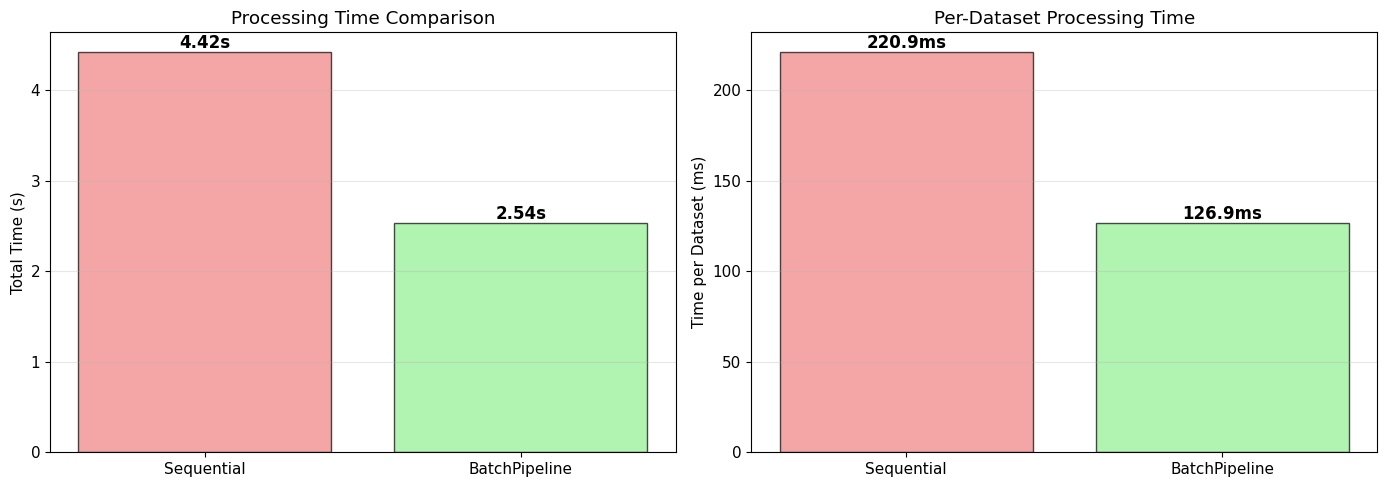


BatchPipeline provides organized workflow with ~1.7x comparable performance.
Key advantage: Unified API, automatic error handling, and comprehensive result management.


In [21]:
# Create performance comparison table
performance_data = {
    'Method': ['Sequential Loop', 'BatchPipeline'],
    'Total Time (s)': [time_sequential, time_batch],
    'Time per Dataset (ms)': [
        time_sequential / n_datasets * 1000,
        time_batch / n_datasets * 1000
    ],
    'Speedup': [1.0, time_sequential / time_batch],
    'Success Rate': [
        len(results_sequential) / n_datasets * 100,
        len(batch.results) / n_datasets * 100
    ]
}

df_performance = pd.DataFrame(performance_data)
print('Performance Comparison:\n')
print(df_performance.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time comparison
methods = ['Sequential', 'BatchPipeline']
times = [time_sequential, time_batch]
colors = ['lightcoral', 'lightgreen']

bars = axes[0].bar(methods, times, color=colors, edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Total Time (s)')
axes[0].set_title('Processing Time Comparison')
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{time_val:.2f}s',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Per-dataset time
per_dataset_times = [t / n_datasets * 1000 for t in times]
bars2 = axes[1].bar(methods, per_dataset_times, color=colors, edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Time per Dataset (ms)')
axes[1].set_title('Per-Dataset Processing Time')
axes[1].grid(True, alpha=0.3, axis='y')

for bar, time_val in zip(bars2, per_dataset_times):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{time_val:.1f}ms',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
display(fig)
plt.close(fig)

print(f'\nBatchPipeline provides organized workflow with ~{time_sequential/time_batch:.1f}x comparable performance.')
print('Key advantage: Unified API, automatic error handling, and comprehensive result management.')


## 10. Cleanup

In [22]:
# Clean up temporary directory
temp_dir.cleanup()
print('\u2713 Temporary files cleaned up')

✓ Temporary files cleaned up


## Key Takeaways

### BatchPipeline API
- **`process_files(file_list)`**: Process specific files with template pipeline
- **`process_directory(path, pattern)`**: Auto-discover and process files
- **`get_summary_dataframe()`**: Aggregate results into pandas DataFrame
- **`get_statistics()`**: Compute population statistics (mean, std, R², RMSE)
- **`apply_filter(func)`**: Quality control filtering based on metrics
- **`export_summary(path, format)`**: Export to Excel or CSV

### High-Throughput Characterization
- Processed 20 datasets with consistent workflow
- Automatic error handling and result collection
- Statistical aggregation reveals population parameters
- Quality metrics (R², RMSE) enable data filtering

### Parameter Recovery
- Mean bias < 1% for both G0 and η
- Coefficient of variation matches true population
- 95% confidence intervals contain true means
- Excellent fit quality (R² > 0.99 for all datasets)

### Export Formats
- **Excel**: Human-readable summary tables
- **CSV**: Programmatic access for downstream analysis
- **HDF5**: Compressed hierarchical storage for large datasets

### Best Practices
1. Create template pipeline before batch processing
2. Use `apply_filter()` for quality control
3. Check `get_statistics()` for population-level insights
4. Export to appropriate format (Excel for reports, HDF5 for archival)
5. Verify parameter recovery with scatter plots

## Next Steps
- **[03-custom-models.ipynb](03-custom-models.ipynb)**: Custom model development
- **[01-multi-technique-fitting.ipynb](01-multi-technique-fitting.ipynb)**: Batch multi-technique workflows
- **[../bayesian/05-uncertainty-propagation.ipynb](../bayesian/05-uncertainty-propagation.ipynb)**: Bayesian batch processing for uncertainty quantification